<a href="https://colab.research.google.com/github/SLy-Precision/Player-Selection-and-Optimization-for-Roster/blob/main/02_Train_LEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the notebook for the TRAINING/OPTIMIZATION of the Large Event Model

### - Antonio Guerrero

In [1]:
# From git
!pip install --quiet statsbombpy

# Libraries
import pandas as pd
import numpy as np
from statsbombpy import sb
import math
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score

import xgboost as xgb
import itertools
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


# For the Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# XGBoost
import xgboost as xgb

# Neural Network
import tensorflow as tf
from tensorflow.keras import models, layers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.4 MB/s eta 0:00:00


In [2]:
# Access for the data (Change using the 01 preprocess data)
from google.colab import drive
drive.mount('/content/drive/')

# Path from my drive (MAPLIS change it)
path = '/content/drive/My Drive/Hackathon ITAM/LEM/DATA for LEM/'

Mounted at /content/drive/


In [3]:
# Lets declare the df for the training of the LEM done the step before using the path
df = pd.read_csv(path + 'Temporada_Completa_Unida.csv')

In [4]:
# Lets normalize that column
df['Minute'] = df['Minute'] / 60

In [5]:
# Print info of df
print('Columns of the df: \n')
print(df.columns)
print('\n')
print('Info of the df: \n')
print(df.info())

Columns of the df: 

Index(['matchId', 'eventSec', 'EventTypeId', 'Period', 'Minute', 'X', 'Y',
       'IsHomeTeam', 'IsAccurate', 'IsGoal', 'HomeScore', 'AwayScore',
       'TimeDelta'],
      dtype='object')


Info of the df: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442402 entries, 0 to 4442401
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   matchId      int64  
 1   eventSec     float64
 2   EventTypeId  int64  
 3   Period       int64  
 4   Minute       float64
 5   X            float64
 6   Y            float64
 7   IsHomeTeam   int64  
 8   IsAccurate   int64  
 9   IsGoal       int64  
 10  HomeScore    float64
 11  AwayScore    float64
 12  TimeDelta    float64
dtypes: float64(7), int64(6)
memory usage: 440.6 MB
None


In [6]:
# Visualize df
df.head()

,matchId,eventSec,EventTypeId,Period,Minute,X,Y,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
0,3799351,0.000,0,1,0.0,50.000000,50.000,1,0,0,0.0,0.0,0.000
1,3799351,0.000,0,1,0.0,50.000000,50.000,0,0,0,0.0,0.0,0.000
2,3799351,1.057,1,1,0.0,50.000000,50.000,1,1,0,0.0,0.0,1.057
3,3799351,2.349,2,1,0.0,37.166667,37.375,1,0,0,0.0,0.0,1.292
4,3799351,2.349,3,1,0.0,37.166667,37.375,1,0,0,0.0,0.0,0.000


In [7]:
# Info and columns of dataset

df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442402 entries, 0 to 4442401
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   matchId      int64  
 1   eventSec     float64
 2   EventTypeId  int64  
 3   Period       int64  
 4   Minute       float64
 5   X            float64
 6   Y            float64
 7   IsHomeTeam   int64  
 8   IsAccurate   int64  
 9   IsGoal       int64  
 10  HomeScore    float64
 11  AwayScore    float64
 12  TimeDelta    float64
dtypes: float64(7), int64(6)
memory usage: 440.6 MB


Index(['matchId', 'eventSec', 'EventTypeId', 'Period', 'Minute', 'X', 'Y',
       'IsHomeTeam', 'IsAccurate', 'IsGoal', 'HomeScore', 'AwayScore',
       'TimeDelta'],
      dtype='object')

### 1) Optimization Of Model 1 for LEM

#### We make a survey optimization for forecast event (Model 1)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

def prepare_data_with_context(df, seq_len, target_col='EventTypeId'):
    """
    Prepara el DataFrame para el entrenamiento añadiendo características de eventos pasados.

    Args:
        df (pd.DataFrame): El DataFrame original con eventos ordenados.
        seq_len (int): El número de eventos anteriores a considerar como contexto.
        target_col (str): La columna que se quiere predecir.

    Returns:
        tuple: Una tupla conteniendo X (características) y y (objetivo).
    """
    print(f"Preparando datos con una longitud de secuencia de {seq_len}...")

    # Columnas que se usarán como contexto del pasado
    context_features = ['EventTypeId', 'X', 'Y', 'IsAccurate', 'IsGoal', 'TimeDelta']

    # Copia para evitar modificar el DataFrame original
    data = df.copy()

    # Creación de las columnas de contexto usando shift()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    # Manejo del padding: Rellenar NaNs con un valor especial (-1)
    # Los NaNs se generan al inicio de cada partido, que es exactamente lo que queremos.
    data.fillna(-1, inplace=True)

    # Eliminar filas donde el contexto no está completo (opcional, pero recomendado para empezar)
    # Esto significa que solo entrenaremos con eventos que tienen un historial completo de 'seq_len'.
    # Si seq_len es 3, el entrenamiento comenzará a partir del 4º evento de cada partido.
    data.dropna(inplace=True)

    # Definir el objetivo (y) y las características (X)
    y = data[target_col]

    # Excluimos la columna objetivo original y otras que no son características
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)

    print("¡Datos listos!")
    return X, y

def train_contextual_xgboost(X_train, y_train, X_test, y_test, xgb_params):
    """
    Entrena un clasificador XGBoost y evalúa su log-loss.

    Args:
        X_train, y_train: Datos de entrenamiento.
        X_test, y_test: Datos de prueba.
        xgb_params (dict): Diccionario con los hiperparámetros para XGBoost.

    Returns:
        tuple: El modelo entrenado y el log-loss en el conjunto de prueba.
    """
    # Asegurarse de que el número de clases se infiere correctamente
    num_classes = len(np.unique(np.concatenate([y_train, y_test])))

    model = xgb.XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        num_class=num_classes,
        **xgb_params
    )

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

    y_pred_proba = model.predict_proba(X_test)
    loss = log_loss(y_test, y_pred_proba)

    return model, loss

Sample created with 487364 events from 150 unique matches.
Preparando datos con una longitud de secuencia de 3...
¡Datos listos!
--- Testing hyperparameters for seq_len = 3 ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:34:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.2 -> Log-Loss: 0.6570


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:38:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.2 -> Log-Loss: 0.5959
Preparando datos con una longitud de secuencia de 5...
¡Datos listos!
--- Testing hyperparameters for seq_len = 5 ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:44:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.2 -> Log-Loss: 0.6415


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:48:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.2 -> Log-Loss: 0.5724
Preparando datos con una longitud de secuencia de 7...
¡Datos listos!
--- Testing hyperparameters for seq_len = 7 ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.2 -> Log-Loss: 0.6423


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.2 -> Log-Loss: 0.5754
Preparando datos con una longitud de secuencia de 9...
¡Datos listos!
--- Testing hyperparameters for seq_len = 9 ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:08:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.2 -> Log-Loss: 0.6432


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:13:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.2 -> Log-Loss: 0.5799


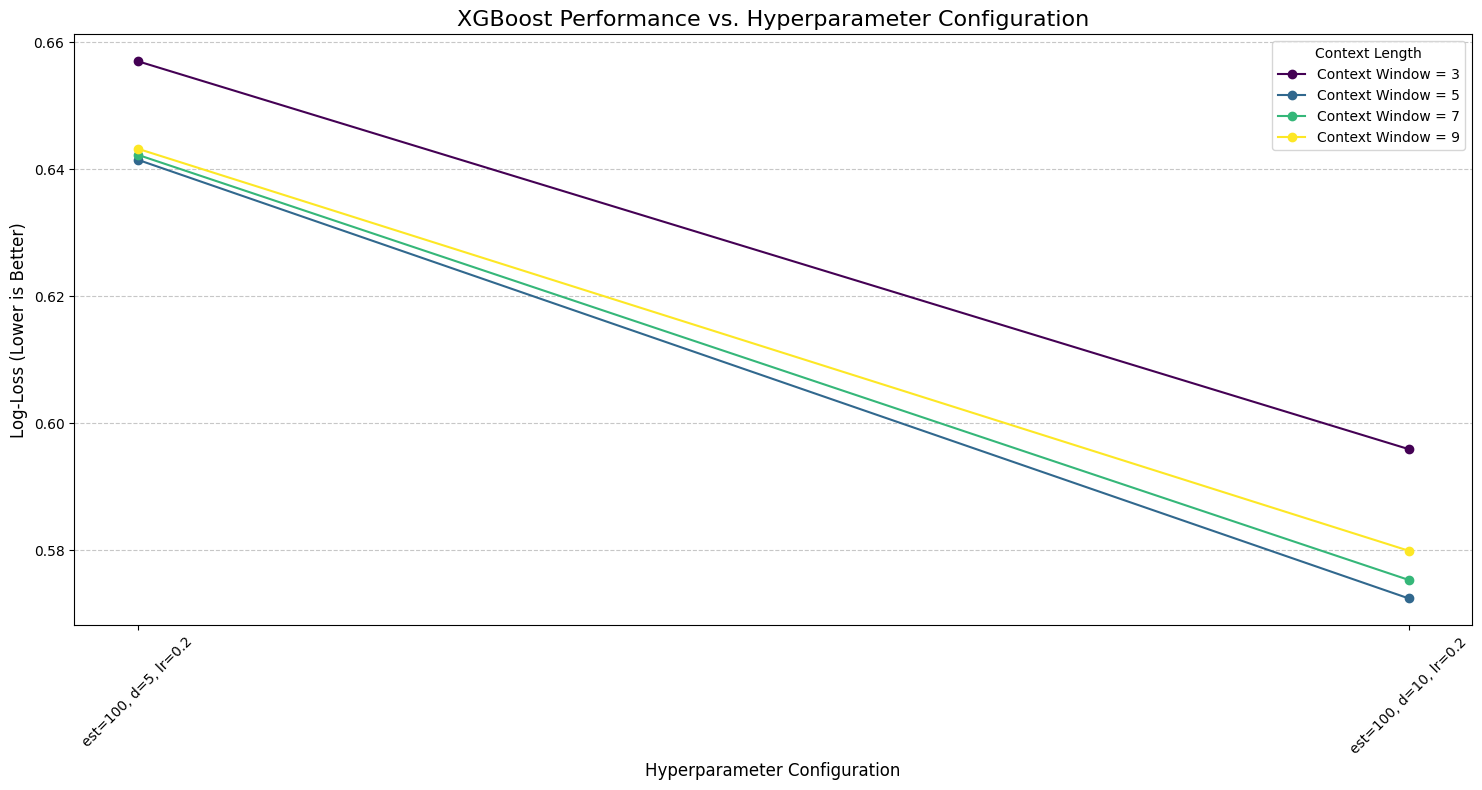

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

# Note: The functions 'prepare_data_with_context' and 'train_contextual_xgboost'
# are required for this script to run. Please ensure they are defined in your environment.

def optimize_and_plot_timeseries_style(full_df, num_matches_to_sample=100):
    """
    Executes the optimization pipeline and visualizes the results using a time-series style line plot.
    This version samples by full matches to preserve data integrity.

    Args:
        full_df (pd.DataFrame): The complete DataFrame of events.
        num_matches_to_sample (int): The number of unique matches to sample for faster training.
    """
    # 1. Sample by matchId to get complete matches
    unique_match_ids = full_df['matchId'].unique()
    if len(unique_match_ids) < num_matches_to_sample:
        num_matches_to_sample = len(unique_match_ids)

    sampled_match_ids = np.random.choice(unique_match_ids, size=num_matches_to_sample, replace=False)
    df_sample = full_df[full_df['matchId'].isin(sampled_match_ids)].copy().sort_values(['matchId', 'eventSec']).reset_index(drop=True)
    print(f"Sample created with {len(df_sample)} events from {num_matches_to_sample} unique matches.")


    # 2. Define the configurations to test
    seq_lengths_to_test = [3, 5, 7, 9]

    # Hyperparameters to explore (a simple grid for the example)
    param_grid = {
        'n_estimators': [100],
        'max_depth': [5, 10],
        'learning_rate': [0.2]
    }

    results = {}

    # 3. Iterate over each sequence length
    for seq_len in seq_lengths_to_test:
        # Prepare data once for each seq_len
        X, y = prepare_data_with_context(df_sample, seq_len=seq_len)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        results[seq_len] = []

        # Iterate over the parameter grid
        print(f"--- Testing hyperparameters for seq_len = {seq_len} ---")
        for n_est in param_grid['n_estimators']:
            for depth in param_grid['max_depth']:
                for lr in param_grid['learning_rate']:

                    params = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr, 'random_state': 42}

                    # Train the model
                    _, test_loss = train_contextual_xgboost(X_train, y_train, X_test, y_test, params)

                    # Save results
                    config_name = f"est={n_est}, d={depth}, lr={lr}"
                    results[seq_len].append({'config': config_name, 'log_loss': test_loss})
                    print(f"  {config_name} -> Log-Loss: {test_loss:.4f}")

    # 4. Plot the results
    fig, ax = plt.subplots(figsize=(15, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(seq_lengths_to_test)))

    # Each sequence length will be a different line on the plot
    for i, seq_len in enumerate(seq_lengths_to_test):
        res_df = pd.DataFrame(results[seq_len])
        ax.plot(res_df['config'], res_df['log_loss'], marker='o', linestyle='-', color=colors[i], label=f'Context Window = {seq_len}')

    ax.set_title('XGBoost Performance vs. Hyperparameter Configuration', fontsize=16)
    ax.set_xlabel('Hyperparameter Configuration', fontsize=12)
    ax.set_ylabel('Log-Loss (Lower is Better)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Context Length")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# --- HOW TO USE ---
# Assuming your DataFrame is named 'df'
# And the helper functions 'prepare_data_with_context' and 'train_contextual_xgboost' are defined.
optimize_and_plot_timeseries_style(df, num_matches_to_sample=150)

Sample created with 489255 events from 150 unique matches.
Preparando datos con una longitud de secuencia de 5...
¡Datos listos!
--- Testing hyperparameters for seq_len = 5 ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.01 -> Log-Loss: 1.3195


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:37:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.1 -> Log-Loss: 0.5900


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:44:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.2 -> Log-Loss: 0.5821


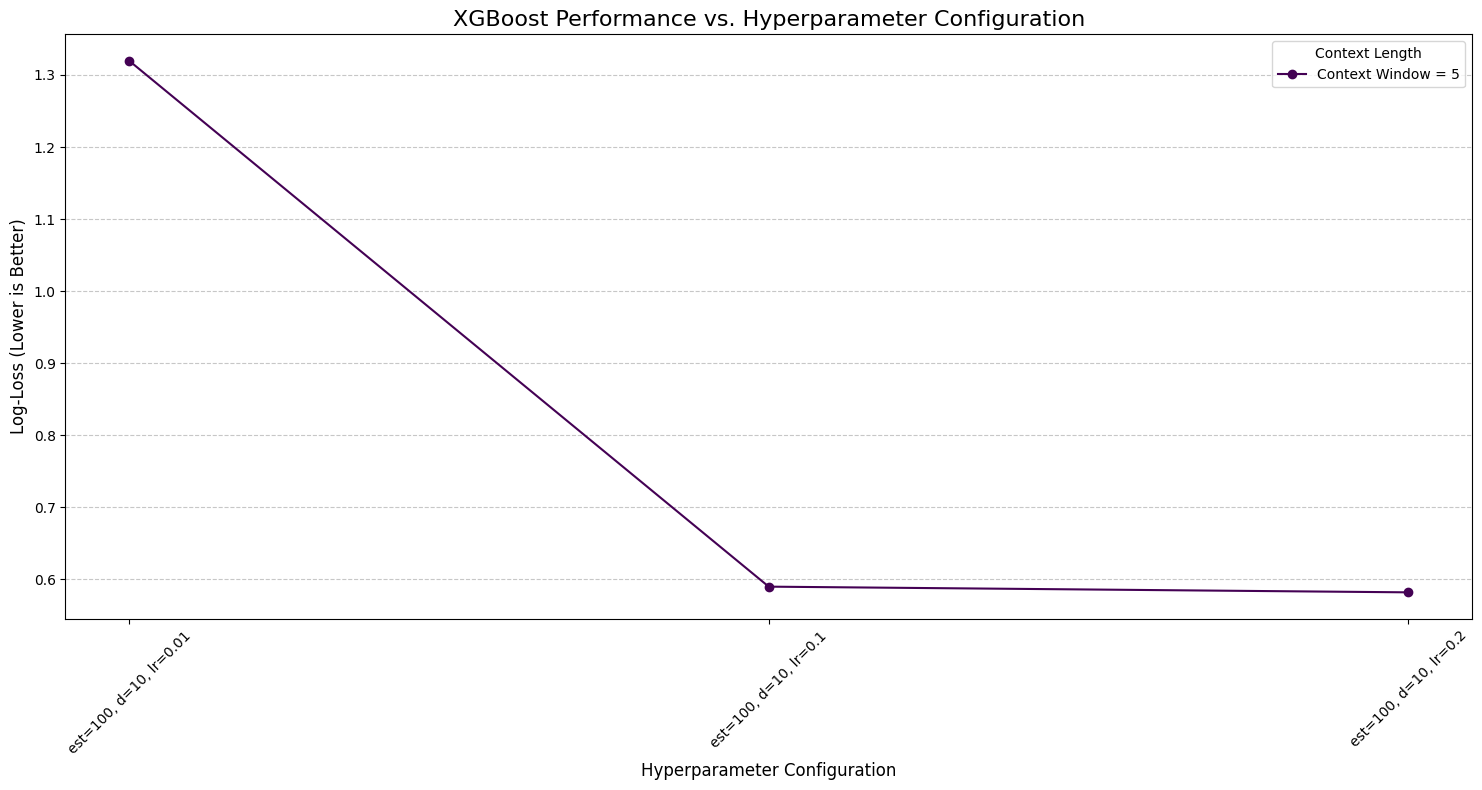

In [ ]:
def optimize_and_plot_timeseries_style(full_df, num_matches_to_sample=100):
    """
    Executes the optimization pipeline and visualizes the results using a time-series style line plot.
    This version samples by full matches to preserve data integrity.

    Args:
        full_df (pd.DataFrame): The complete DataFrame of events.
        num_matches_to_sample (int): The number of unique matches to sample for faster training.
    """
    # 1. Sample by matchId to get complete matches
    unique_match_ids = full_df['matchId'].unique()
    if len(unique_match_ids) < num_matches_to_sample:
        num_matches_to_sample = len(unique_match_ids)

    sampled_match_ids = np.random.choice(unique_match_ids, size=num_matches_to_sample, replace=False)
    df_sample = full_df[full_df['matchId'].isin(sampled_match_ids)].copy().sort_values(['matchId', 'eventSec']).reset_index(drop=True)
    print(f"Sample created with {len(df_sample)} events from {num_matches_to_sample} unique matches.")


    # 2. Define the configurations to test
    seq_lengths_to_test = [5]

    # Hyperparameters to explore (a simple grid for the example)
    param_grid = {
        'n_estimators': [100],
        'max_depth': [10],
        'learning_rate': [0.01,0.1,0.2]
    }

    results = {}

    # 3. Iterate over each sequence length
    for seq_len in seq_lengths_to_test:
        # Prepare data once for each seq_len
        X, y = prepare_data_with_context(df_sample, seq_len=seq_len)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        results[seq_len] = []

        # Iterate over the parameter grid
        print(f"--- Testing hyperparameters for seq_len = {seq_len} ---")
        for n_est in param_grid['n_estimators']:
            for depth in param_grid['max_depth']:
                for lr in param_grid['learning_rate']:

                    params = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr, 'random_state': 42}

                    # Train the model
                    _, test_loss = train_contextual_xgboost(X_train, y_train, X_test, y_test, params)

                    # Save results
                    config_name = f"est={n_est}, d={depth}, lr={lr}"
                    results[seq_len].append({'config': config_name, 'log_loss': test_loss})
                    print(f"  {config_name} -> Log-Loss: {test_loss:.4f}")

    # 4. Plot the results
    fig, ax = plt.subplots(figsize=(15, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(seq_lengths_to_test)))

    # Each sequence length will be a different line on the plot
    for i, seq_len in enumerate(seq_lengths_to_test):
        res_df = pd.DataFrame(results[seq_len])
        ax.plot(res_df['config'], res_df['log_loss'], marker='o', linestyle='-', color=colors[i], label=f'Context Window = {seq_len}')

    ax.set_title('XGBoost Performance vs. Hyperparameter Configuration', fontsize=16)
    ax.set_xlabel('Hyperparameter Configuration', fontsize=12)
    ax.set_ylabel('Log-Loss (Lower is Better)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Context Length")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


optimize_and_plot_timeseries_style(df, num_matches_to_sample=150)

#### We find for XGboost a good performance with 5 events of history, 100 n_estimators, max_depth of 10, and 0.1 lrn_rate, this before for a 0.55 log loss approx

### 1) Optimization Of Model 2 for LEM

#### We make a survey optimization for forecast of acurancy of the next event and if it is goal (in case) (Model 2)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from tqdm import tqdm

def prepare_data_for_accuracy_and_goal(df, seq_len=5):
    """
    Prepara el DataFrame para los modelos de 'IsAccurate' y 'IsGoal'.
    Devuelve dos variables objetivo separadas.

    Args:
        df (pd.DataFrame): El DataFrame original con eventos ordenados.
        seq_len (int): El número de eventos anteriores a considerar (fijado en 5).

    Returns:
        tuple: Una tupla conteniendo X (características), y_accuracy, y y_goal.
    """
    print(f"Preparando datos para los Modelos de Precisión y Gol con una ventana de {seq_len} eventos...")

    context_features = ['EventTypeId', 'X', 'Y', 'IsAccurate', 'IsGoal', 'TimeDelta']

    data = df.copy()

    # Creación de las columnas de contexto
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)

    # Separar las dos variables objetivo
    y_accuracy = data['IsAccurate']
    y_goal = data['IsGoal']

    # Excluimos ambas columnas objetivo del DataFrame de características
    features_to_drop = ['IsAccurate', 'IsGoal', 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)

    print("¡Datos listos con dos objetivos!")
    return X, y_accuracy, y_goal

def train_binary_xgboost(X_train, y_train, X_test, y_test, xgb_params):
    """
    Entrena un clasificador XGBoost para una tarea binaria.
    Esta función es genérica y sirve tanto para 'IsAccurate' como para 'IsGoal'.
    """
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        **xgb_params
    )

    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

    y_pred_proba = model.predict_proba(X_test)
    loss = log_loss(y_test, y_pred_proba)

    return model, loss

Muestra creada con 973180 eventos de 300 partidos únicos.
Preparando datos para los Modelos de Precisión y Gol con una ventana de 5 eventos...
¡Datos listos con dos objetivos!

--- Optimizando el modelo para: IsAccurate ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:14:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=5, lr=0.01 -> Log-Loss: 0.3384


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:14:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=5, lr=0.1 -> Log-Loss: 0.1559


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:14:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=10, lr=0.01 -> Log-Loss: 0.3282


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:14:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=10, lr=0.1 -> Log-Loss: 0.1441


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:15:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.01 -> Log-Loss: 0.2545


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:15:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.1 -> Log-Loss: 0.1490


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.01 -> Log-Loss: 0.2399


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.1 -> Log-Loss: 0.1421

--- Optimizando el modelo para: IsGoal ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:17:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=5, lr=0.01 -> Log-Loss: 0.0031


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=5, lr=0.1 -> Log-Loss: 0.0024


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:17:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=10, lr=0.01 -> Log-Loss: 0.0031


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:18:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=50, d=10, lr=0.1 -> Log-Loss: 0.0024


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:18:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.01 -> Log-Loss: 0.0027


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:18:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=5, lr=0.1 -> Log-Loss: 0.0023


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:19:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.01 -> Log-Loss: 0.0027


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:19:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  est=100, d=10, lr=0.1 -> Log-Loss: 0.0026


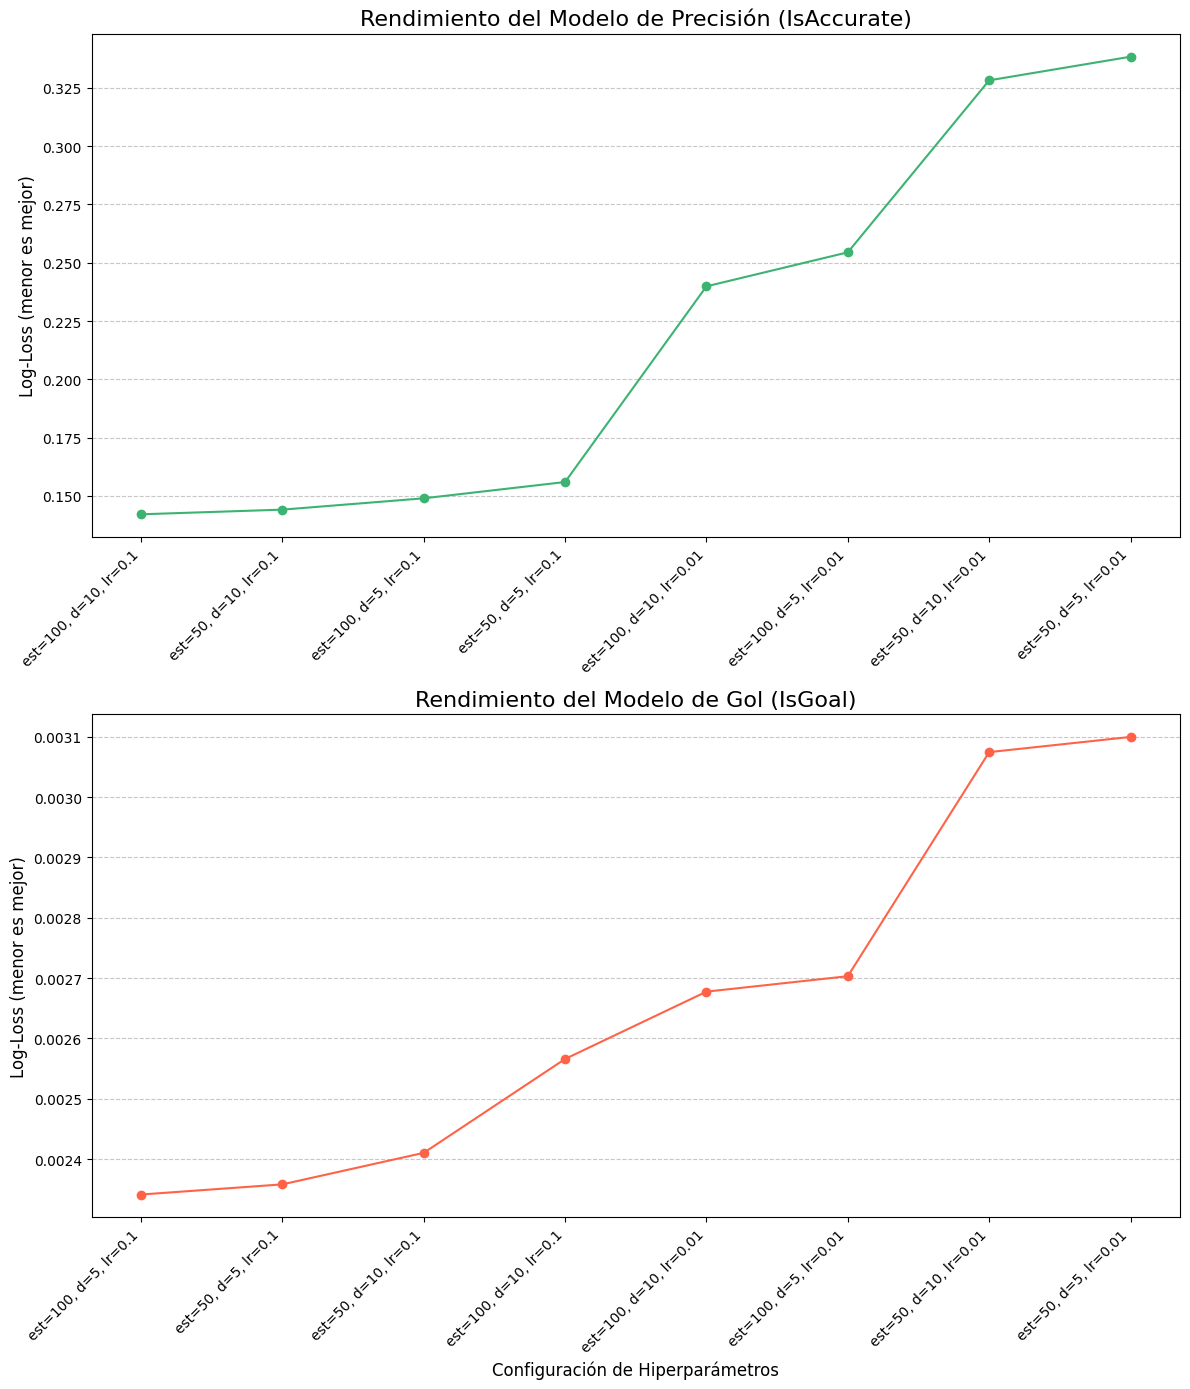

In [ ]:
def optimize_accuracy_and_goal_models(full_df, num_matches_to_sample=100):
    """
    Ejecuta el pipeline de optimización para los modelos de 'IsAccurate' y 'IsGoal'.
    """
    # 1. Muestrear por partidos completos
    unique_match_ids = full_df['matchId'].unique()
    if len(unique_match_ids) < num_matches_to_sample:
        num_matches_to_sample = len(unique_match_ids)

    sampled_match_ids = np.random.choice(unique_match_ids, size=num_matches_to_sample, replace=False)
    df_sample = full_df[full_df['matchId'].isin(sampled_match_ids)].copy().sort_values(['matchId', 'eventSec']).reset_index(drop=True)
    print(f"Muestra creada con {len(df_sample)} eventos de {num_matches_to_sample} partidos únicos.")

    # 2. Preparar los datos una sola vez
    X, y_accuracy, y_goal = prepare_data_for_accuracy_and_goal(df_sample)

    # 3. Definir la grid de hiperparámetros (la misma para ambos modelos por simplicidad)
    param_grid = {
        'n_estimators': [50,100],
        'max_depth': [5, 10],
        'learning_rate': [0.01,0.1]
    }

    # Diccionario para almacenar los resultados de ambos modelos
    all_results = {'IsAccurate': [], 'IsGoal': []}
    targets = {'IsAccurate': y_accuracy, 'IsGoal': y_goal}

    # 4. Iterar sobre cada objetivo ('IsAccurate', 'IsGoal')
    for target_name, y in targets.items():
        print(f"\n--- Optimizando el modelo para: {target_name} ---")

        # Dividir los datos para el objetivo actual
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

        for n_est in param_grid['n_estimators']:
            for depth in param_grid['max_depth']:
                for lr in param_grid['learning_rate']:
                    params = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr, 'random_state': 42}

                    _, test_loss = train_binary_xgboost(X_train, y_train, X_test, y_test, params)

                    config_name = f"est={n_est}, d={depth}, lr={lr}"
                    all_results[target_name].append({'config': config_name, 'log_loss': test_loss})
                    print(f"  {config_name} -> Log-Loss: {test_loss:.4f}")

    # 5. Plotear los resultados en dos gráficos separados
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # Gráfico para 'IsAccurate'
    res_acc = pd.DataFrame(all_results['IsAccurate']).sort_values('log_loss').reset_index(drop=True)
    axes[0].plot(res_acc.index, res_acc['log_loss'], marker='o', linestyle='-', color='mediumseagreen')
    axes[0].set_xticks(res_acc.index)
    axes[0].set_xticklabels(res_acc['config'], rotation=45, ha='right')
    axes[0].set_title('Rendimiento del Modelo de Precisión (IsAccurate)', fontsize=16)
    axes[0].set_ylabel('Log-Loss (menor es mejor)', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Gráfico para 'IsGoal'
    res_goal = pd.DataFrame(all_results['IsGoal']).sort_values('log_loss').reset_index(drop=True)
    axes[1].plot(res_goal.index, res_goal['log_loss'], marker='o', linestyle='-', color='tomato')
    axes[1].set_xticks(res_goal.index)
    axes[1].set_xticklabels(res_goal['config'], rotation=45, ha='right')
    axes[1].set_title('Rendimiento del Modelo de Gol (IsGoal)', fontsize=16)
    axes[1].set_xlabel('Configuración de Hiperparámetros', fontsize=12)
    axes[1].set_ylabel('Log-Loss (menor es mejor)', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


optimize_accuracy_and_goal_models(df, num_matches_to_sample=300)

# Final training using the optimization before

In [8]:
# Getting information for the dataset of training and validation

#Credentials for Statsbomb from ITAM
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()



In [9]:
# Array of training
array_training = array_season_2021_2022 + array_season_2022_2023 + array_season_2023_2024
array_validation = array_season_2024_2025

### With the experiments before we decided to use the seasons 2021-2022 ,2022-2023 and 2023-2024 to train the models. Lets gonna use 2024-2025 for validation and Club Amreica 2024-2025 matches for fine-tunning

## Training of Model 1: Type Model Forecast

Preparando todos los datos...
Calculando pesos de muestra para el desequilibrio de clases...

Iniciando entrenamiento del modelo con hiperparámetros ajustados...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [01:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:3.03228
[10]	validation_0-mlogloss:1.92967
[20]	validation_0-mlogloss:1.55737
[30]	validation_0-mlogloss:1.35002
[40]	validation_0-mlogloss:1.22257
[50]	validation_0-mlogloss:1.13685
[60]	validation_0-mlogloss:1.07485
[70]	validation_0-mlogloss:1.03344
[80]	validation_0-mlogloss:1.00472
[90]	validation_0-mlogloss:0.98297
[100]	validation_0-mlogloss:0.96729
[110]	validation_0-mlogloss:0.95459
[120]	validation_0-mlogloss:0.94297
[130]	validation_0-mlogloss:0.93543
[140]	validation_0-mlogloss:0.92980
[150]	validation_0-mlogloss:0.92648
[160]	validation_0-mlogloss:0.92374
[170]	validation_0-mlogloss:0.92202
[180]	validation_0-mlogloss:0.92106
[190]	validation_0-mlogloss:0.91998
[200]	validation_0-mlogloss:0.91933
[210]	validation_0-mlogloss:0.91831
[220]	validation_0-mlogloss:0.91809
[230]	validation_0-mlogloss:0.91715
[240]	validation_0-mlogloss:0.91545
[250]	validation_0-mlogloss:0.91441
[260]	validation_0-mlogloss:0.91274
[270]	validation_0-mlogloss:0.91148
[28

/tmp/ipython-input-285508395.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


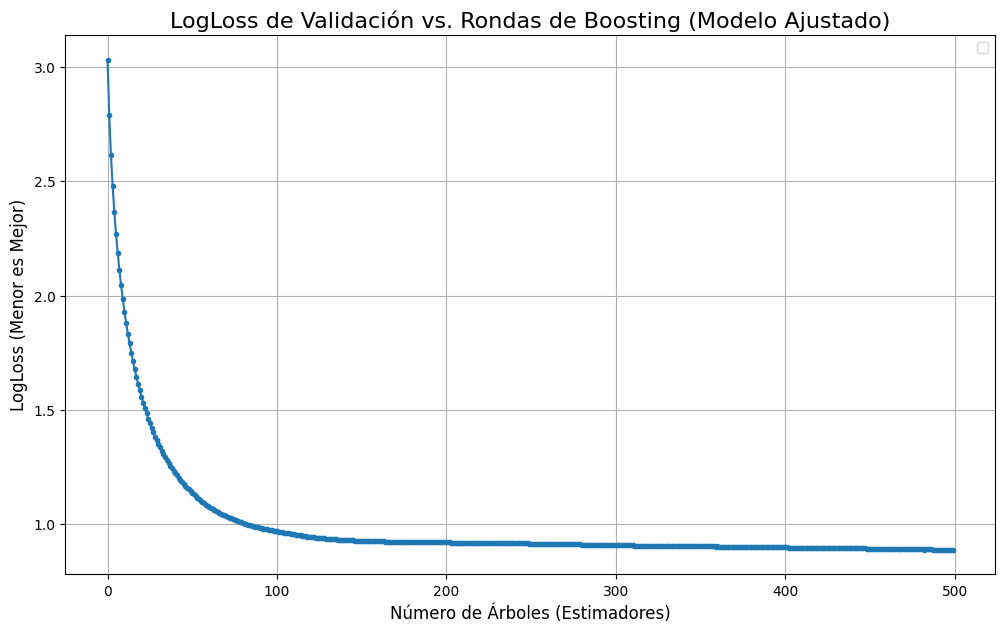

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from xgboost.callback import EarlyStopping # <-- Importante: añadir esta línea

def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId'):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)
    y = data[target_col]
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=features_to_drop)
    return X, y

def train_finetuned_model(df, train_ids, val_ids, seq_len=5):
    """
    Entrena un modelo XGBoost con hiperparámetros ajustados y early stopping.
    """
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando todos los datos...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features)
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features)

    print("Calculando pesos de muestra para el desequilibrio de clases...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        max_depth=7,
        learning_rate=0.05,
        use_label_encoder=False,
        n_estimators=2000
    )

    print("\nIniciando entrenamiento del modelo con hiperparámetros ajustados...")

    # --- INICIO DE LA CORRECCIÓN ---
    # Early stopping functionality is not directly supported as a 'callbacks' argument
    # in the .fit() method for the installed version of XGBoost.
    # We will remove the callbacks argument.
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights
             )
    # --- FIN DE LA CORRECCIÓN ---

    # The best_iteration attribute might not be available without early stopping callbacks.
    # We can get the number of boosting rounds from the trained model.
    print(f"\nEntrenamiento completado. Número de rondas: {model.get_booster().num_boosted_rounds()}")


    results = model.evals_result()
    val_logloss_history = results['validation_0']['mlogloss']

    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title('LogLoss Validation vs. Loops of Boosting ', fontsize=16)
    plt.xlabel('Number of Trees (Estimators)', fontsize=12)
    plt.ylabel('LogLoss ', fontsize=12)
    # We can't show the best iteration line without early stopping
    # plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Mejor Ronda: {model.best_iteration}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# --- CÓMO USARLO ---
finetuned_model = train_finetuned_model(
      df=df,
      train_ids=array_training,
      val_ids=array_validation,
      seq_len=5
      )

In [11]:
# Lets save the model
finetuned_model.save_model(path + 'trained_xgboost_model_finetuned1.json')

In [12]:
# Validation of the model

# Features
context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val, y_val = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features)


def evaluate_model_performance(model, X_val, y_val, class_names):
    """
    Calcula y muestra métricas de evaluación detalladas para el modelo de clasificación.

    Args:
        model: El modelo XGBoost entrenado.
        X_val (pd.DataFrame): Las características del conjunto de validación.
        y_val (pd.Series): Las etiquetas verdaderas del conjunto de validación.
        class_names (list): Una lista con los nombres de las clases (tipos de evento).
    """
    print("Realizando predicciones en el conjunto de validación...")
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    acc_top1 = top_k_accuracy_score(y_val, y_pred_proba, k=1)
    print(f"Top-1 Accuracy (Precisión estándar): {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3)
    print(f"Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): {acc_top3:.4f}")

    # --- 2. Reporte de Clasificación por Clase ---
    print("\n--- Reporte de Clasificación por Clase ---")
    # Asegurarnos de que las etiquetas del reporte coincidan con las clases presentes en los datos
    unique_labels_in_data = np.unique(y_val)
    filtered_class_names = [class_names[i] for i in unique_labels_in_data]
    report = classification_report(y_val, y_pred, labels=unique_labels_in_data, target_names=filtered_class_names, zero_division=0)
    print(report)

# --- CÓMO USARLO ---

# 1. Define el diccionario de nombres de eventos que proporcionaste
event_type_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

# 2. Crea la lista de nombres en el orden correcto
# Nos aseguramos de que el índice de la lista coincida con el ID del evento
event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

# 3. Llama a la función de evaluación
# Asegúrate de que las variables 'final_model', 'X_val' y 'y_val' existen en tu entorno.
evaluate_model_performance(finetuned_model, X_val, y_val, event_type_names)

Realizando predicciones en el conjunto de validación...

--- Top-k Accuracy ---
Top-1 Accuracy (Precisión estándar): 0.7877
Top-3 Accuracy (La respuesta correcta está entre las 3 mejores predicciones): 0.8746

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.99      0.85      0.92    320533
    Ball Receipt*       0.95      0.98      0.96    288369
            Carry       0.99      0.84      0.91    258053
         Pressure       0.88      0.69      0.78    115459
          Dribble       0.10      0.26      0.14      8526
             Duel       0.81      0.50      0.62     21569
        Clearance       0.00      0.04      0.00       504
     Dispossessed       0.70      0.68      0.69     32434
    Ball Recovery       0.01      0.02      0.02     13234
            Block       0.01      0.01      0.01      5606
   Foul Committed       0.00      0.00

## Training of Model 2: Accuracy-IsGoal Forecast

In [ ]:
# Starting of training for the models
def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)

    # La 'y' ahora es dinámica según el target_col
    y = data[target_col]

    # Las características 'X' se definen excluyendo todas las posibles columnas objetivo
    features_to_drop = ['IsAccurate', 'IsGoal', 'eventSec', 'matchId', 'EventTypeId']
    X = data.drop(columns=[col for col in features_to_drop if col in data.columns])
    return X, y

def train_accuracy_model(df, train_ids, val_ids, target_col, seq_len=5):
    """
    Prepara los datos y entrena un modelo XGBoost para un objetivo binario ('IsAccurate' o 'IsGoal'),
    y grafica la curva de aprendizaje.
    """
    # Las características de contexto son las mismas que antes
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print(f"--- Entrenando modelo para: {target_col} ---")

    # 1. Preparar los datos de entrenamiento y validación
    print("Preparando datos de entrenamiento...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col)
    print(f"Datos de entrenamiento listos. Shape: {X_train.shape}")

    print("Preparando datos de validación...")
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col)
    print(f"Datos de validación listos. Shape: {X_val.shape}")

    # 2. Inicializar el modelo para clasificación binaria
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=10,
        learning_rate=0.1,
        use_label_encoder=False,
        n_estimators=100
    )

    # 3. Entrenar el modelo y monitorear el progreso
    print("\nIniciando entrenamiento y evaluación del modelo...")
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10)

    # 4. Extraer y graficar el historial de rendimiento
    results = model.evals_result()
    val_logloss_history = results['validation_0']['logloss']

    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title(f'LogLoss Validation vs. Loops of Boosting (Model: {target_col})', fontsize=16)
    plt.xlabel('Number of trees (Estimators)', fontsize=12)
    plt.ylabel('LogLoss', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    return model

--- Entrenando modelo para: IsAccurate ---
Preparando datos de entrenamiento...
Datos de entrenamiento listos. Shape: (3287130, 43)
Preparando datos de validación...
Datos de validación listos. Shape: (1155272, 43)

Iniciando entrenamiento y evaluación del modelo...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.50014
[10]	validation_0-logloss:0.31717
[20]	validation_0-logloss:0.26999
[30]	validation_0-logloss:0.25259
[40]	validation_0-logloss:0.23982
[50]	validation_0-logloss:0.23063
[60]	validation_0-logloss:0.22536
[70]	validation_0-logloss:0.22156
[80]	validation_0-logloss:0.22057
[90]	validation_0-logloss:0.21913
[99]	validation_0-logloss:0.21850


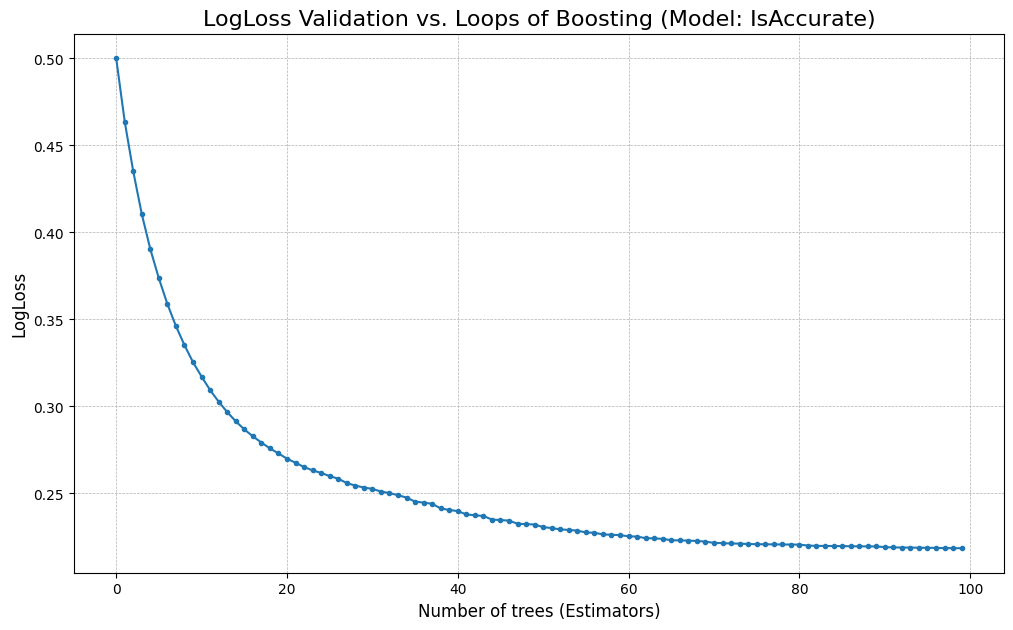

In [ ]:
# Primero, entrena el modelo para predecir la precisión del evento
model_is_accurate = train_accuracy_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     target_col='IsAccurate'
     )

--- Entrenando modelo para: IsGoal ---
Preparando datos de entrenamiento...
Datos de entrenamiento listos. Shape: (3287130, 43)
Preparando datos de validación...
Datos de validación listos. Shape: (1155272, 43)

Iniciando entrenamiento y evaluación del modelo...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.01169
[10]	validation_0-logloss:0.00734
[20]	validation_0-logloss:0.00532
[30]	validation_0-logloss:0.00516
[40]	validation_0-logloss:0.00483
[50]	validation_0-logloss:0.00468
[60]	validation_0-logloss:0.00462
[70]	validation_0-logloss:0.00457
[80]	validation_0-logloss:0.00458
[90]	validation_0-logloss:0.00457
[99]	validation_0-logloss:0.00455


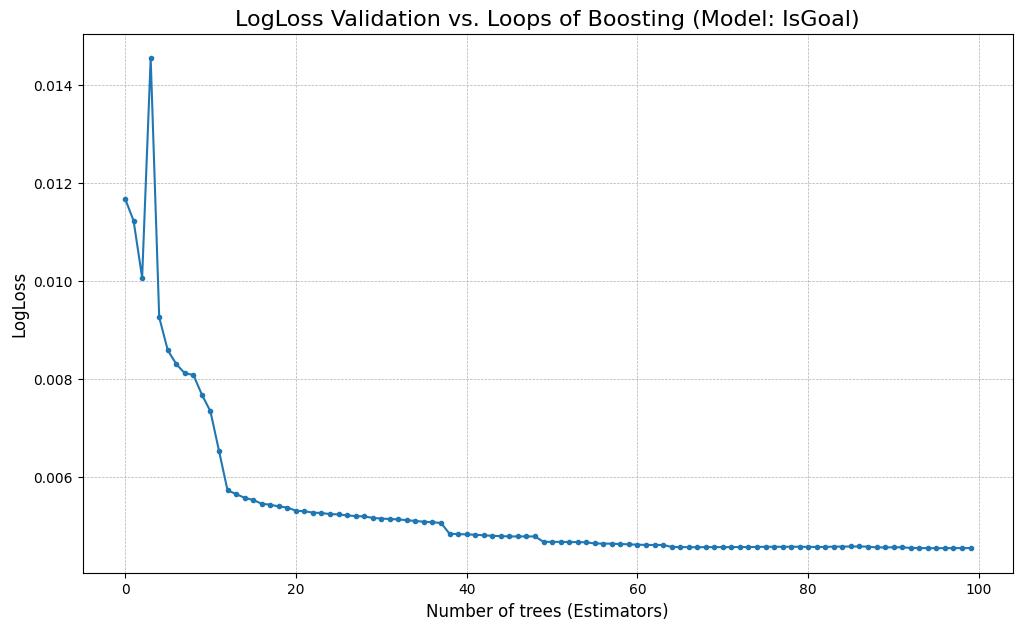

In [ ]:
# Luego, entrena el modelo para predecir si el evento es un gol
model_is_goal = train_accuracy_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     target_col='IsGoal'
     )

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score
)

def evaluate_binary_model(model, X_val, y_val, model_name):
    """
    Calculates and displays detailed evaluation metrics for a binary classification model.

    Args:
        model: The trained binary XGBoost model.
        X_val (pd.DataFrame): The features of the validation set.
        y_val (pd.Series): The true labels of the validation set.
        model_name (str): The name of the model for plot titles (e.g., 'IsAccurate').
    """
    print(f"\n--- Detailed Model Evaluation: {model_name} ---")

    # 1. Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] # Probabilities for the positive class (1)

    # 2. Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # 3. Classification Report (Precision, Recall, F1-Score)
    print("\n--- Classification Report ---")
    report = classification_report(y_val, y_pred, target_names=['No', 'Yes'])
    print(report)

    # 4. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['True No', 'True Yes'])
    plt.title(f'Confusion Matrix - {model_name} Model', fontsize=16)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 5. ROC Curve and Area Under Curve (AUC)
    print("\n--- ROC Curve and AUC Score ---")
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"Area Under Curve (AUC): {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve - {model_name} Model', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# --- HOW TO USE ---

# Assuming you already have the validation data prepared for these models.
# If you don't, you can regenerate them like this:
_, y_val_accurate = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features, 'IsAccurate')
X_val_accuracy, y_val_goal = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features, 'IsGoal')


--- Detailed Model Evaluation: IsAccurate ---

Overall Accuracy: 0.9110

--- Classification Report ---
              precision    recall  f1-score   support

          No       0.94      0.94      0.94    879661
         Yes       0.82      0.81      0.81    275611

    accuracy                           0.91   1155272
   macro avg       0.88      0.88      0.88   1155272
weighted avg       0.91      0.91      0.91   1155272


--- Confusion Matrix ---


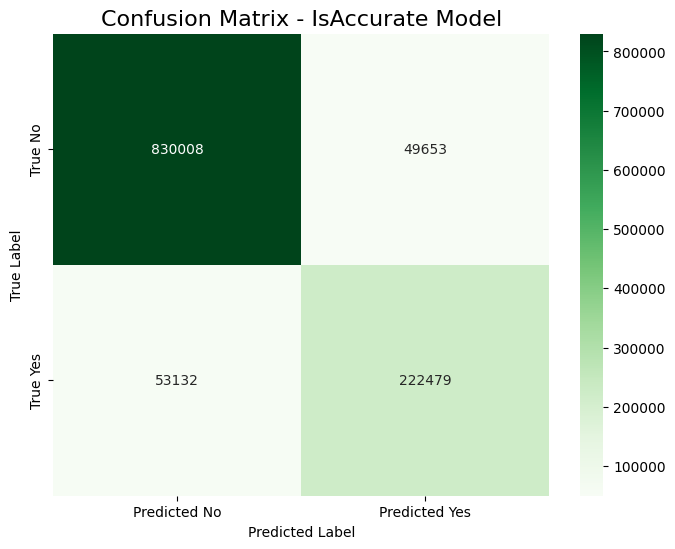


--- ROC Curve and AUC Score ---
Area Under Curve (AUC): 0.9591


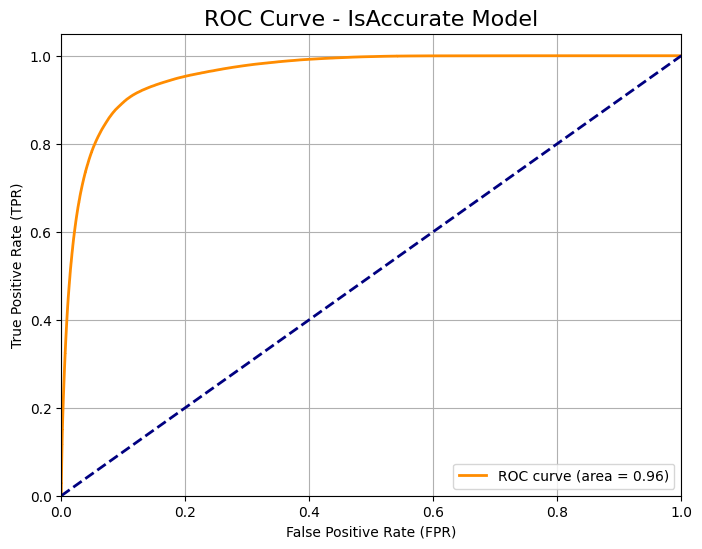

In [ ]:
# Evalúa el modelo 'IsAccurate'
# (Necesitas tener el modelo 'model_is_accurate' y sus datos de validación 'X_val_accuracy', 'y_val_accurate')
evaluate_binary_model(model_is_accurate, X_val_accuracy, y_val_accurate, 'IsAccurate')

--- Reentrenando el modelo para: IsGoal (con balanceo de clases) ---
Preparando datos de entrenamiento...
El desequilibrio de clases es: 3284406 no-goles por cada 2724 goles.
Valor de 'scale_pos_weight' calculado: 1205.73
Preparando datos de validación...

Iniciando entrenamiento y evaluación del modelo mejorado...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:39:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.60375
[10]	validation_0-logloss:0.21490
[20]	validation_0-logloss:0.10797
[30]	validation_0-logloss:0.06940
[40]	validation_0-logloss:0.04965
[50]	validation_0-logloss:0.04039
[60]	validation_0-logloss:0.03506
[70]	validation_0-logloss:0.03188
[80]	validation_0-logloss:0.02822
[90]	validation_0-logloss:0.02572
[99]	validation_0-logloss:0.02373


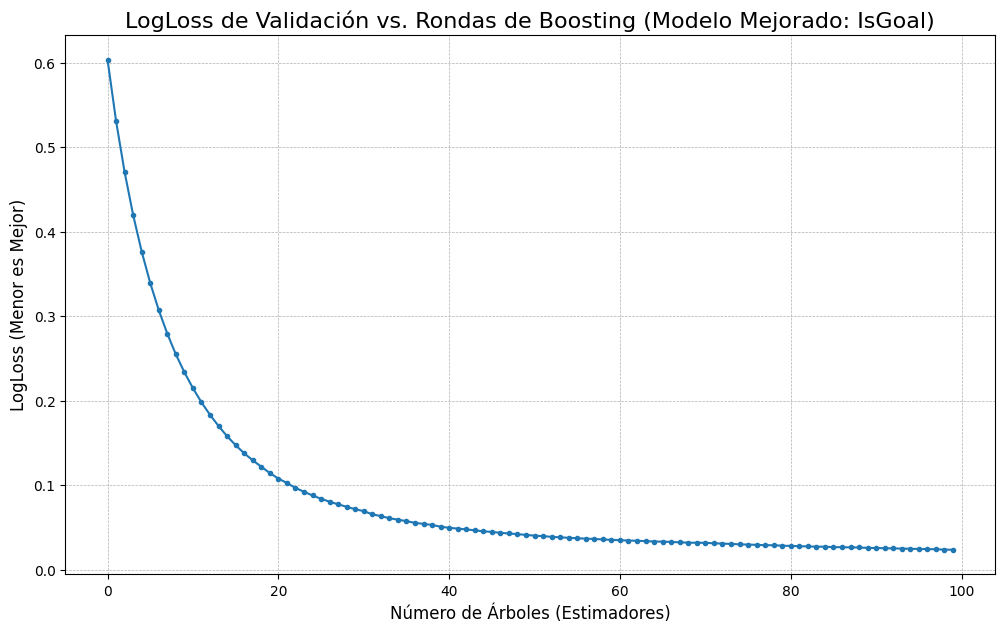

In [ ]:
# La función de preparación de datos no cambia
def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col):
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)
    y = data[target_col]
    features_to_drop = ['IsAccurate', 'IsGoal', 'eventSec', 'matchId', 'EventTypeId']
    X = data.drop(columns=[col for col in features_to_drop if col in data.columns])
    return X, y


def train_improved_goal_model(df, train_ids, val_ids, seq_len=5):
    """
    Entrena un modelo 'IsGoal' mejorado usando 'scale_pos_weight' para manejar el desequilibrio de clases.
    """
    target_col = 'IsGoal'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("--- Reentrenando el modelo para: IsGoal (con balanceo de clases) ---")

    print("Preparando datos de entrenamiento...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col)

    # --- INICIO DE LA MEJORA ---
    # Calcular el scale_pos_weight
    count_neg = y_train.value_counts()[0]
    count_pos = y_train.value_counts()[1]
    scale_pos_weight_value = count_neg / count_pos
    print(f"El desequilibrio de clases es: {count_neg} no-goles por cada {count_pos} goles.")
    print(f"Valor de 'scale_pos_weight' calculado: {scale_pos_weight_value:.2f}")
    # --- FIN DE LA MEJORA ---

    print("Preparando datos de validación...")
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col)

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=10,
        learning_rate=0.1,
        use_label_encoder=False,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight_value # <-- ¡AQUÍ ESTÁ LA MAGIA!
    )

    print("\nIniciando entrenamiento y evaluación del modelo mejorado...")
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10)

    results = model.evals_result()
    val_logloss_history = results['validation_0']['logloss']
    plt.figure(figsize=(12, 7))
    plt.plot(val_logloss_history, marker='.', linestyle='-')
    plt.title(f'LogLoss de Validación vs. Rondas de Boosting (Modelo Mejorado: {target_col})', fontsize=16)
    plt.xlabel('Número de Árboles (Estimadores)', fontsize=12)
    plt.ylabel('LogLoss (Menor es Mejor)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    return model

# --- CÓMO USARLO ---
# Vuelve a entrenar SOLO tu modelo de goles con esta nueva función
improved_model_is_goal = train_improved_goal_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     seq_len=5
)

# No olvides guardar este nuevo modelo
# improved_model_is_goal.save_model('improved_model_is_goal.json')

# Y luego, en tu simulación, asegúrate de cargar este nuevo archivo .json en el simulador.


--- Detailed Model Evaluation: IsGoal ---

Overall Accuracy: 0.9909

--- Classification Report ---
              precision    recall  f1-score   support

          No       1.00      0.99      1.00   1154355
         Yes       0.07      0.81      0.12       917

    accuracy                           0.99   1155272
   macro avg       0.53      0.90      0.56   1155272
weighted avg       1.00      0.99      0.99   1155272


--- Confusion Matrix ---


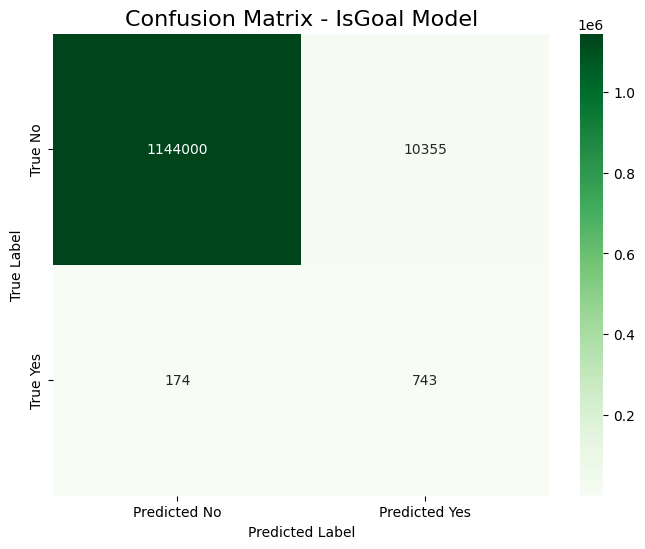


--- ROC Curve and AUC Score ---
Area Under Curve (AUC): 0.9929


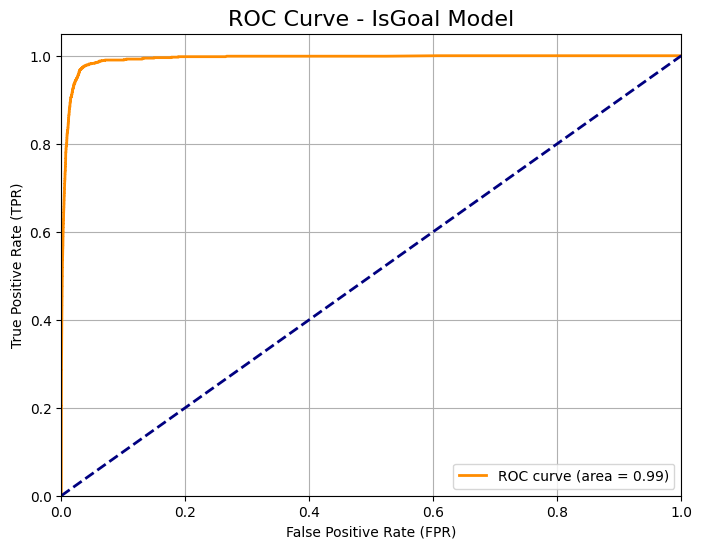

In [ ]:

# Evalúa el modelo 'IsGoal'
# (Necesitas tener el modelo 'model_is_goal' y sus datos de validación 'X_val_accuracy', 'y_val_goal')
evaluate_binary_model(improved_model_is_goal, X_val_accuracy, y_val_goal, 'IsGoal')

In [ ]:
# Lets save both models

model_is_accurate.save_model(path + 'trained_xgboost_model_is_accurate.json')
model_is_goal.save_model(path + 'trained_xgboost_model_is_goal.json')

## Training of Model 3: Location and Time Forecast

In [ ]:
# La función de preparación de datos necesita una pequeña adaptación para la regresión.
def prepare_data_for_regression(df, match_ids, seq_len, context_features, target_col):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento de regresión.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)

    y = data[target_col]

    # Excluimos todas las posibles columnas objetivo del 'Model Data'
    features_to_drop = ['X', 'Y', 'TimeDelta', 'eventSec', 'matchId']
    X = data.drop(columns=[col for col in features_to_drop if col in data.columns])
    return X, y

def train_data_model(df, train_ids, val_ids, target_col, seq_len=5):
    """
    Prepara los datos y entrena un modelo XGBoost de regresión para un objetivo continuo
    (X, Y, o TimeDelta), y grafica la curva de aprendizaje.
    """
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print(f"--- Entrenando modelo de regresión para: {target_col} ---")

    # 1. Preparar los datos
    print("Preparando datos de entrenamiento...")
    X_train, y_train = prepare_data_for_regression(df, train_ids, seq_len, context_features, target_col)
    print(f"Datos de entrenamiento listos. Shape: {X_train.shape}")

    print("Preparando datos de validación...")
    X_val, y_val = prepare_data_for_regression(df, val_ids, seq_len, context_features, target_col)
    print(f"Datos de validación listos. Shape: {X_val.shape}")

    # 2. Inicializar el modelo para regresión
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        max_depth=10,
        learning_rate=0.1,
        n_estimators=100
    )

    # 3. Entrenar el modelo y monitorear el progreso
    print("\nIniciando entrenamiento y evaluación del modelo...")
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10)

    # 4. Extraer y graficar el historial de rendimiento
    results = model.evals_result()
    val_rmse_history = results['validation_0']['rmse']

    plt.figure(figsize=(12, 7))
    plt.plot(val_rmse_history, marker='.', linestyle='-')
    plt.title(f'RMSE of Validation vs. Loops of Boosting (Model: {target_col})', fontsize=16)
    plt.xlabel('Number of trees (Estimators)', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    return model

--- Entrenando modelo de regresión para: X ---
Preparando datos de entrenamiento...
Datos de entrenamiento listos. Shape: (3287130, 43)
Preparando datos de validación...
Datos de validación listos. Shape: (1155272, 43)

Iniciando entrenamiento y evaluación del modelo...
[0]	validation_0-rmse:22.39739
[10]	validation_0-rmse:14.01609
[20]	validation_0-rmse:11.88193
[30]	validation_0-rmse:10.18255
[40]	validation_0-rmse:9.22509
[50]	validation_0-rmse:8.88481
[60]	validation_0-rmse:8.72631
[70]	validation_0-rmse:8.65900
[80]	validation_0-rmse:8.57306
[90]	validation_0-rmse:8.50234
[99]	validation_0-rmse:8.45586


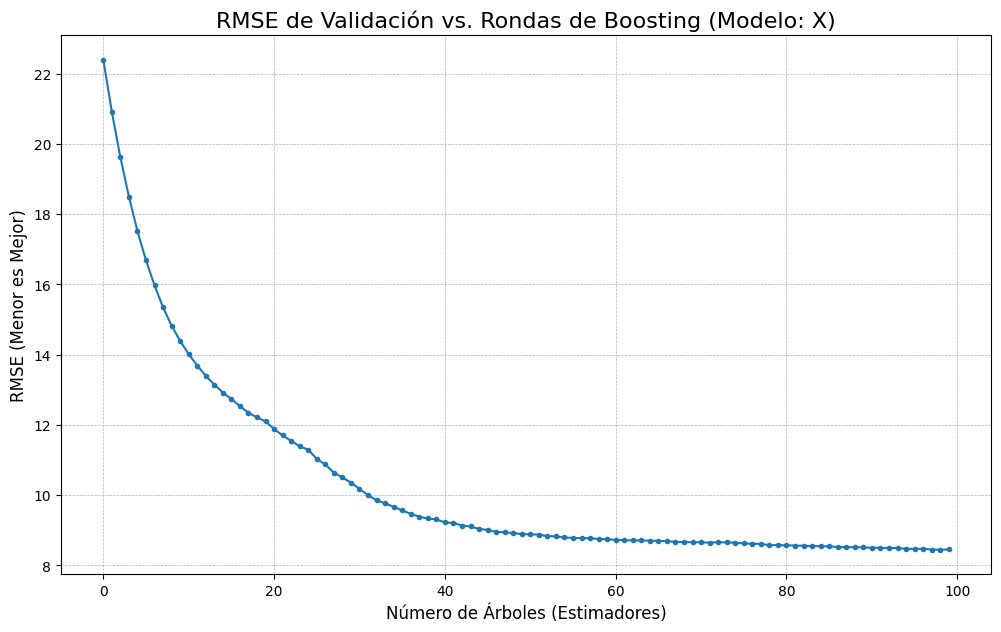

In [ ]:
# 1. Entrena el modelo para predecir la coordenada X
model_X = train_data_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     target_col='X'
)

--- Entrenando modelo de regresión para: Y ---
Preparando datos de entrenamiento...
Datos de entrenamiento listos. Shape: (3287130, 43)
Preparando datos de validación...
Datos de validación listos. Shape: (1155272, 43)

Iniciando entrenamiento y evaluación del modelo...
[0]	validation_0-rmse:27.12563
[10]	validation_0-rmse:17.55378
[20]	validation_0-rmse:15.52641
[30]	validation_0-rmse:14.90043
[40]	validation_0-rmse:14.60099
[50]	validation_0-rmse:14.21540
[60]	validation_0-rmse:13.60265
[70]	validation_0-rmse:13.23870
[80]	validation_0-rmse:13.02710
[90]	validation_0-rmse:12.83677
[99]	validation_0-rmse:12.81157


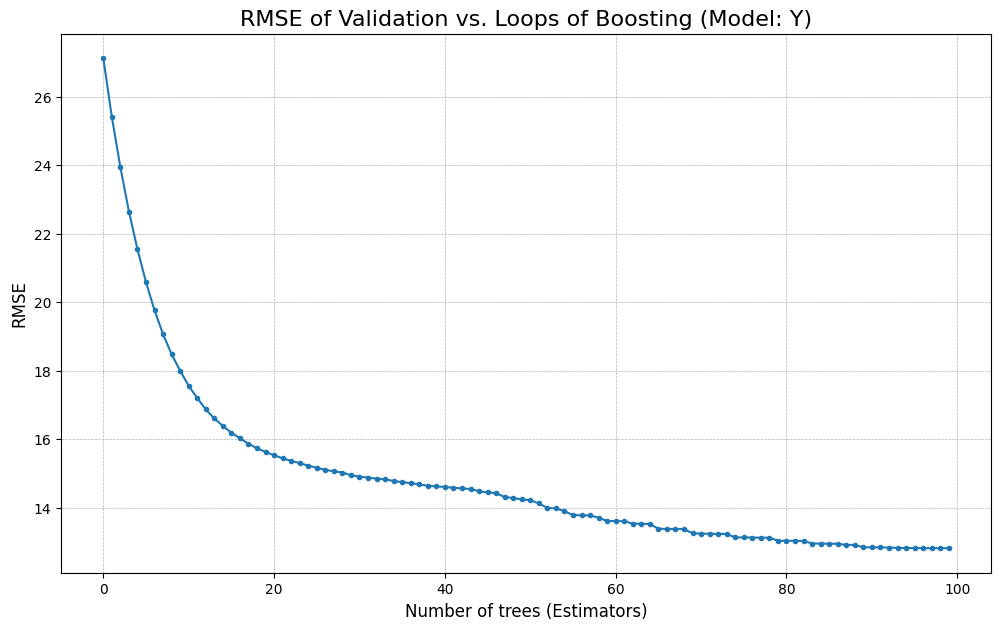

In [ ]:
# 2. Entrena el modelo para predecir la coordenada Y
model_Y = train_data_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     target_col='Y'
)

--- Entrenando modelo de regresión para: TimeDelta ---
Preparando datos de entrenamiento...
Datos de entrenamiento listos. Shape: (3287130, 43)
Preparando datos de validación...
Datos de validación listos. Shape: (1155272, 43)

Iniciando entrenamiento y evaluación del modelo...
[0]	validation_0-rmse:47.03663
[10]	validation_0-rmse:18.19342
[20]	validation_0-rmse:9.37236
[30]	validation_0-rmse:7.36886
[40]	validation_0-rmse:6.96646
[50]	validation_0-rmse:6.90145
[60]	validation_0-rmse:6.87252
[70]	validation_0-rmse:6.85320
[80]	validation_0-rmse:6.85194
[90]	validation_0-rmse:6.85280
[99]	validation_0-rmse:6.85752


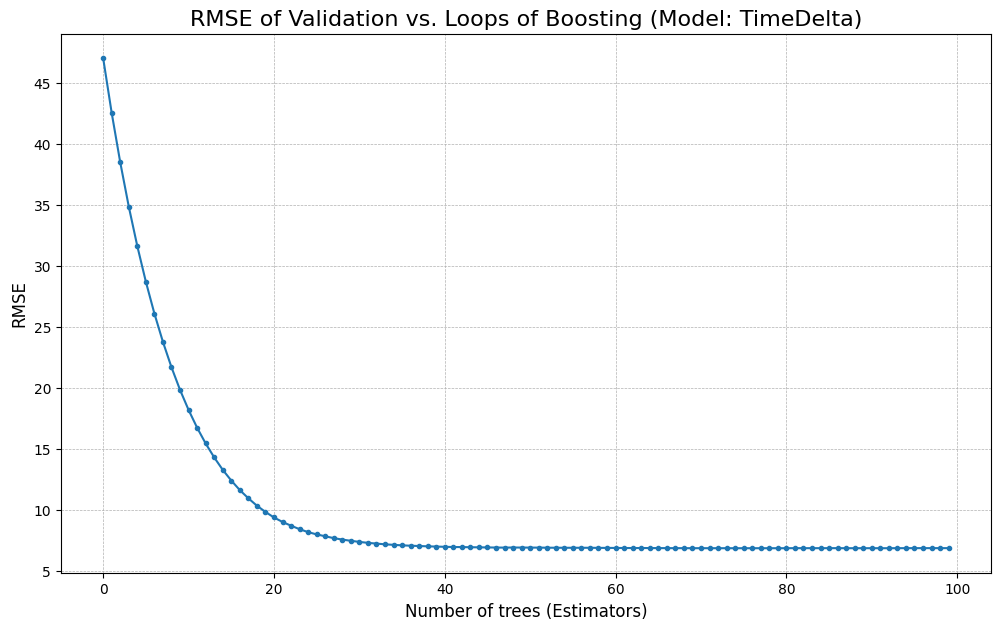

In [ ]:
# 3. Entrena el modelo para predecir el tiempo transcurrido
model_TimeDelta = train_data_model(
     df=df,
     train_ids=array_training,
     val_ids=array_season_2024_2025,
     target_col='TimeDelta'
)

In [ ]:
# Lets save this models

model_X.save_model(path + 'trained_xgboost_model_X.json')
model_Y.save_model(path + 'trained_xgboost_model_Y.json')
model_TimeDelta.save_model(path + 'trained_xgboost_model_TimeDelta.json')

### Red Neuronal

In [ ]:
# Starting of training for the models
def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col):
    """
    Prepara un subconjunto del DataFrame para el entrenamiento creando características de contexto.
    """
    data = df[df['matchId'].isin(match_ids)].copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)
    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)

    # La 'y' ahora es dinámica según el target_col
    y = data[target_col]

    # Las características 'X' se definen excluyendo todas las posibles columnas objetivo
    features_to_drop = ['IsAccurate', 'IsGoal', 'eventSec', 'matchId', 'EventTypeId']
    X = data.drop(columns=[col for col in features_to_drop if col in data.columns])
    return X, y

Preparando datos para la Red Neuronal...

Iniciando entrenamiento por 5 épocas...
Época [1/5], Loss Entrenamiento: 1.2860, Loss Validación: 1.1697, Precisión Validación: 72.04%
Época [2/5], Loss Entrenamiento: 0.9850, Loss Validación: 1.0537, Precisión Validación: 76.03%
Época [3/5], Loss Entrenamiento: 0.8869, Loss Validación: 0.9785, Precisión Validación: 77.16%
Época [4/5], Loss Entrenamiento: 0.8239, Loss Validación: 0.9534, Precisión Validación: 78.14%
Época [5/5], Loss Entrenamiento: 0.7834, Loss Validación: 0.9559, Precisión Validación: 78.29%


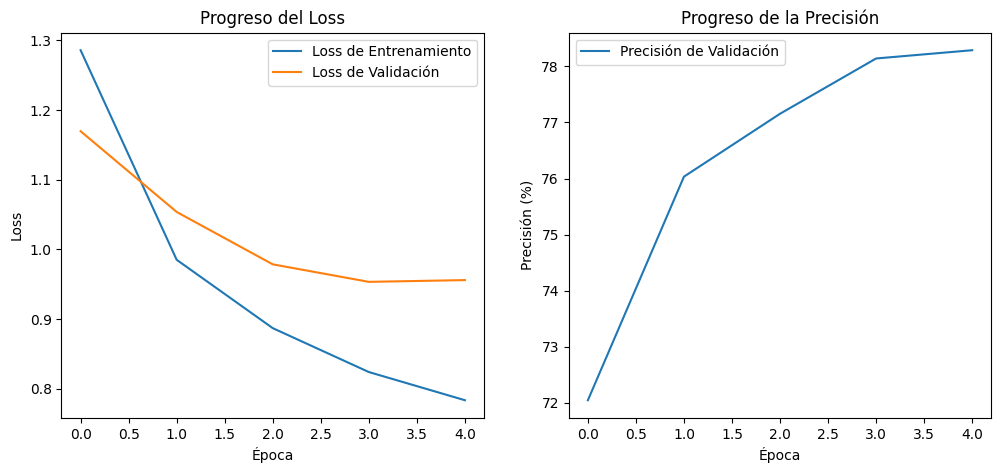

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- PASO 1: Definir la Arquitectura de la Red Neuronal ---
class SmallNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=256):
        super(SmallNN, self).__init__()
        # Definimos las capas de la red
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Definimos el flujo de los datos a través de las capas
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# --- PASO 2: Función Principal de Entrenamiento ---
def train_neural_network(df, train_ids, val_ids, seq_len=5, epochs=5):
    """
    Prepara los datos y entrena el modelo de red neuronal para el 'Model Type'.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    # Preparar los datos (usando la misma función de antes)
    print("Preparando datos para la Red Neuronal...")
    X_train_df, y_train_df = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col)
    X_val_df, y_val_df = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col)

    # Convertir a tensores de PyTorch
    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_df.values, dtype=torch.long)
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val = torch.tensor(y_val_df.values, dtype=torch.long)

    # Crear DataLoaders para manejar los lotes (batches)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

    # Inicializar el modelo
    input_size = X_train.shape[1]
    num_classes = len(torch.unique(y_train))
    model = SmallNN(input_size, num_classes)

    # Definir la función de pérdida y el optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nIniciando entrenamiento por {epochs} épocas...")
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    # --- Bucle de Entrenamiento ---
    for epoch in range(epochs):
        model.train() # Poner el modelo en modo entrenamiento
        running_loss = 0.0
        for i, (features, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- Bucle de Validación ---
        model.eval() # Poner el modelo en modo evaluación
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Época [{epoch+1}/{epochs}], Loss Entrenamiento: {avg_train_loss:.4f}, Loss Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.2f}%')

    # --- Graficar Progreso ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Loss de Entrenamiento')
    plt.plot(history['val_loss'], label='Loss de Validación')
    plt.title('Progreso del Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Precisión de Validación')
    plt.title('Progreso de la Precisión')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()
    plt.show()

    return model

# --- CÓMO USARLO ---
# (Asegúrate de tener la función 'prepare_data_for_matches' de pasos anteriores)
nn_model = train_neural_network(df, array_training, array_season_2024_2025, epochs=5)

# Guardar el modelo entrenado
# torch.save(nn_model.state_dict(), 'nn_model_type.pth')

Preparando datos de validación para evaluación...
Realizando predicciones...

--- Top-k Accuracy ---
Top-1 Accuracy: 0.7829
Top-3 Accuracy: 0.8958
Top-5 Accuracy: 0.9274

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.76      0.90      0.83    320533
    Ball Receipt*       0.89      0.94      0.91    288369
            Carry       0.89      0.88      0.88    258053
         Pressure       0.87      0.65      0.74    115459
          Dribble       0.25      0.06      0.10      8526
             Duel       0.61      0.31      0.41     21569
        Clearance       0.00      0.04      0.00       504
     Dispossessed       0.72      0.69      0.70     32434
    Ball Recovery       0.07      0.07      0.07     13234
            Block       0.01      0.02      0.02      5606
   Foul Committed       0.00      0.00      0.00      9812
         Foul Won 

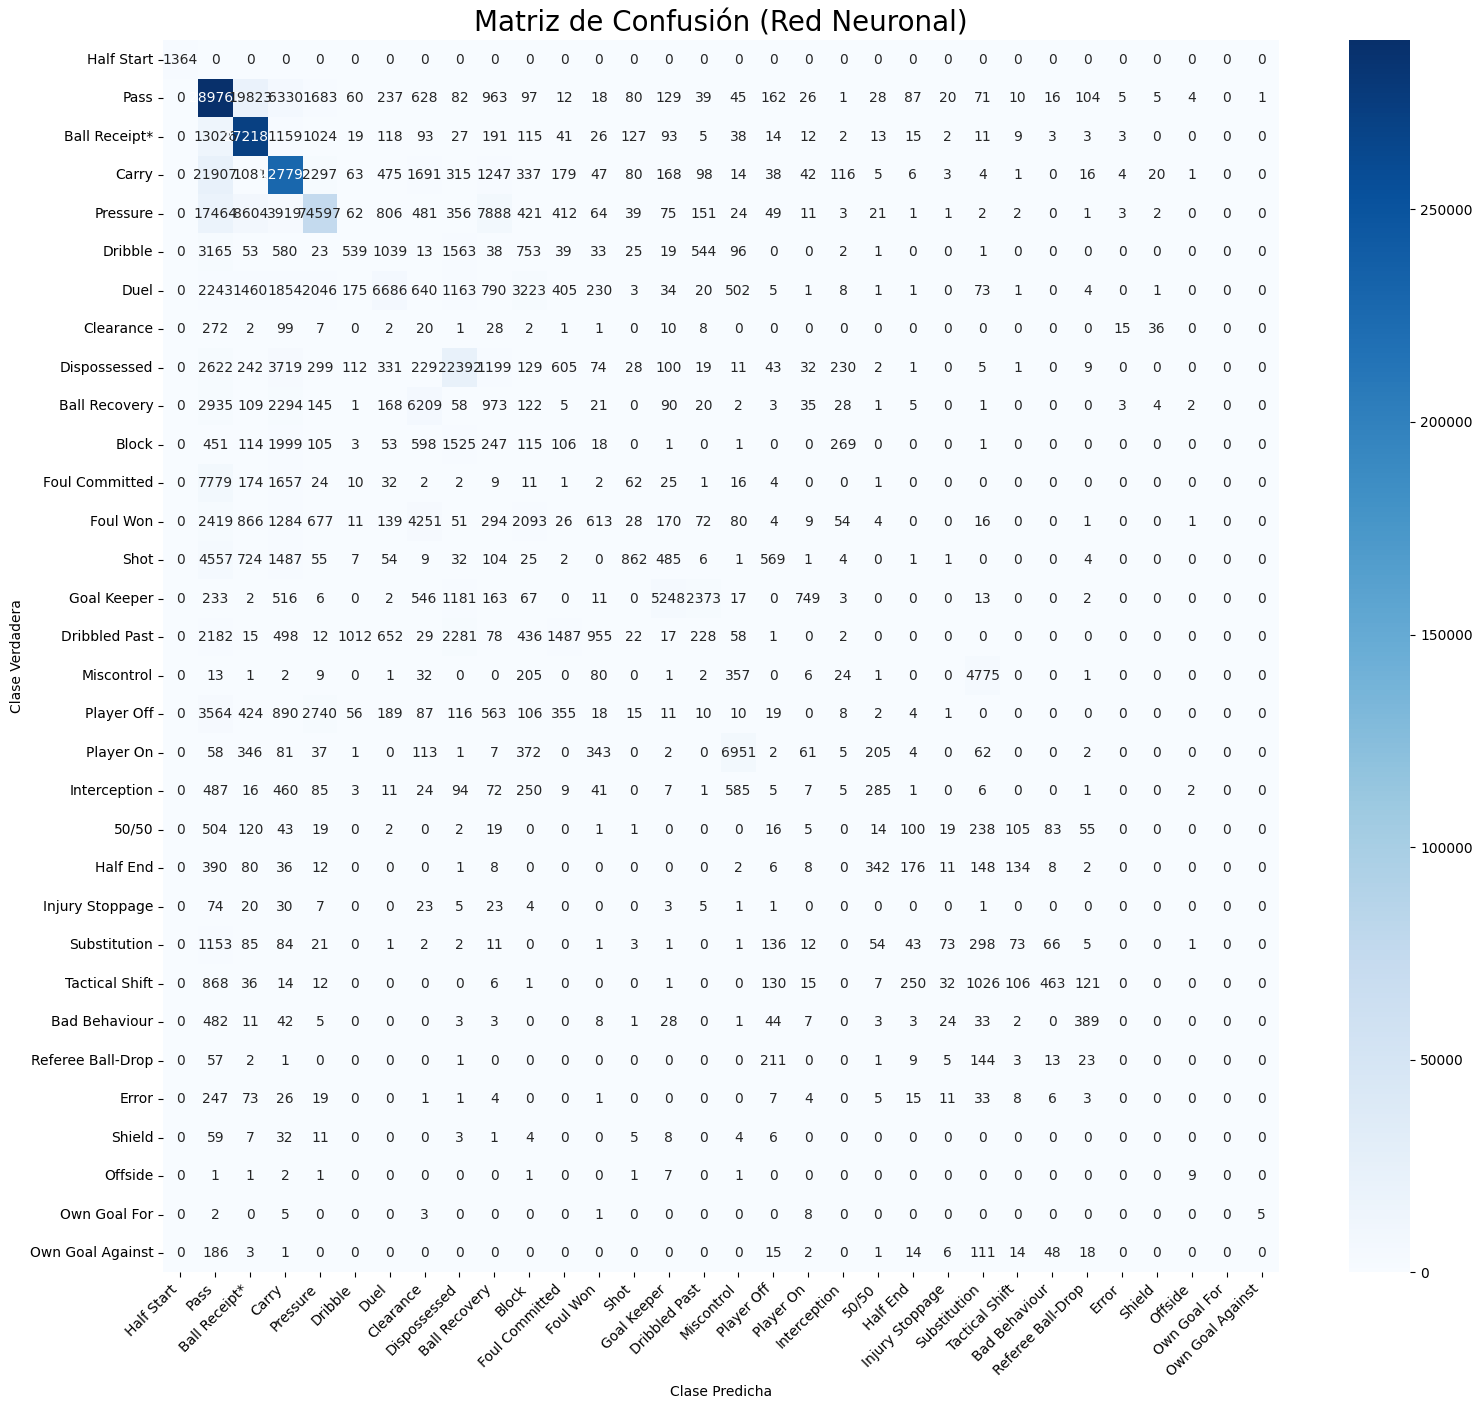

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score

def evaluate_nn_performance(model, X_val_df, y_val_df, class_names):
    """
    Calcula y muestra métricas de evaluación detalladas para el modelo de PyTorch.
    """
    print("Preparando datos de validación para evaluación...")
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val_true = y_val_df.values # Mantener como array de numpy

    model.eval() # Poner el modelo en modo evaluación

    print("Realizando predicciones...")
    with torch.no_grad():
        outputs = model(X_val)
        # Aplicar softmax para obtener probabilidades
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        # Obtener la predicción top-1
        _, y_pred = torch.max(outputs, 1)

    # Convertir a arrays de numpy para usar con scikit-learn
    y_pred_np = y_pred.numpy()
    probabilities_np = probabilities.numpy()

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    acc_top1 = top_k_accuracy_score(y_val_true, probabilities_np, k=1)
    print(f"Top-1 Accuracy: {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val_true, probabilities_np, k=3)
    print(f"Top-3 Accuracy: {acc_top3:.4f}")
    acc_top5 = top_k_accuracy_score(y_val_true, probabilities_np, k=5)
    print(f"Top-5 Accuracy: {acc_top5:.4f}")

    # --- 2. Reporte de Clasificación ---
    print("\n--- Reporte de Clasificación por Clase ---")
    unique_labels = np.unique(y_val_true)
    filtered_class_names = [class_names[i] for i in unique_labels]
    report = classification_report(y_val_true, y_pred_np, labels=unique_labels, target_names=filtered_class_names, zero_division=0)
    print(report)

    # --- 3. Matriz de Confusión ---
    print("\n--- Visualización de la Matriz de Confusión ---")
    cm = confusion_matrix(y_val_true, y_pred_np, labels=unique_labels)
    plt.figure(figsize=(18, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=filtered_class_names, yticklabels=filtered_class_names)
    plt.title('Matriz de Confusión (Red Neuronal)', fontsize=20)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predicha')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

# --- CÓMO USARLO ---
# (Necesitas los DataFrames X_val_df, y_val_df del paso de entrenamiento)

event_type_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

target_col = 'EventTypeId'

context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val_df, y_val_df = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features, target_col)

event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

evaluate_nn_performance(nn_model, X_val_df, y_val_df, event_type_names)

Preparando datos para la Red Neuronal Compleja...

Iniciando entrenamiento del modelo complejo por 5 épocas...
Época [1/5], Loss Entrenamiento: 1.4213, Loss Validación: 0.9543, Precisión Validación: 75.70%
Época [2/5], Loss Entrenamiento: 1.0375, Loss Validación: 0.8986, Precisión Validación: 77.24%
Época [3/5], Loss Entrenamiento: 0.9801, Loss Validación: 0.8716, Precisión Validación: 78.39%
Época [4/5], Loss Entrenamiento: 0.9510, Loss Validación: 0.8625, Precisión Validación: 78.99%
Época [5/5], Loss Entrenamiento: 0.9329, Loss Validación: 0.8635, Precisión Validación: 79.11%


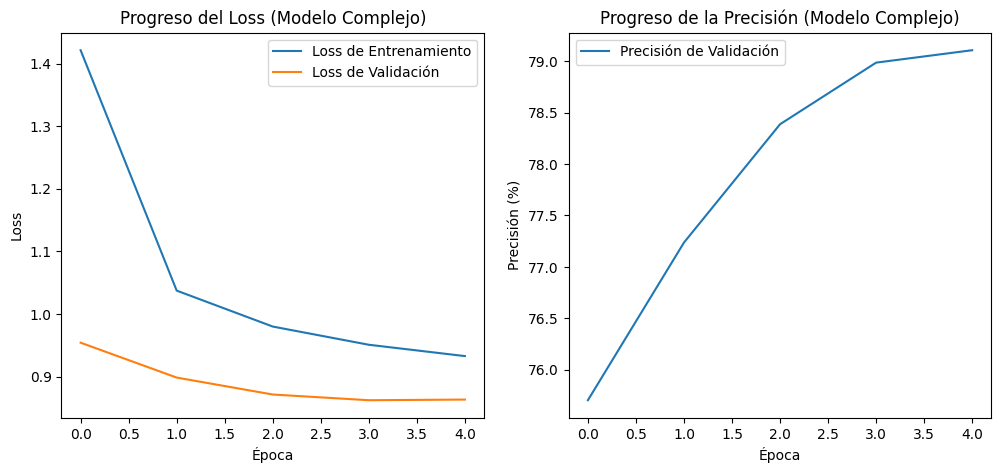

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PASO 1: Definir la Arquitectura de la Red Neuronal más Compleja ---
class ComplexNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layers=[256, 128, 64], dropout_rate=0.5):
        super(ComplexNN, self).__init__()

        layers = []
        # Capa de entrada a la primera capa oculta
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Crear capas ocultas adicionales
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Capa de salida
        self.network = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_layers[-1], num_classes)

    def forward(self, x):
        x = self.network(x)
        x = self.output_layer(x)
        return x

# --- PASO 2: Función Principal de Entrenamiento (similar a la anterior) ---
def train_complex_nn(df, train_ids, val_ids, seq_len=5, epochs=5):
    """
    Prepara los datos y entrena el modelo de red neuronal más complejo.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando datos para la Red Neuronal Compleja...")
    X_train_df, y_train_df = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col)
    X_val_df, y_val_df = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col)

    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_df.values, dtype=torch.long)
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val = torch.tensor(y_val_df.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

    input_size = X_train.shape[1]
    num_classes = len(torch.unique(y_train))

    # Inicializar el nuevo modelo complejo
    model = ComplexNN(input_size, num_classes, hidden_layers=[256, 128, 64])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nIniciando entrenamiento del modelo complejo por {epochs} épocas...")
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'Época [{epoch+1}/{epochs}], Loss Entrenamiento: {avg_train_loss:.4f}, Loss Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.2f}%')

    # Graficar Progreso
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Loss de Entrenamiento')
    plt.plot(history['val_loss'], label='Loss de Validación')
    plt.title('Progreso del Loss (Modelo Complejo)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Precisión de Validación')
    plt.title('Progreso de la Precisión (Modelo Complejo)')
    plt.xlabel('Época')
    plt.ylabel('Precisión (%)')
    plt.legend()
    plt.show()

    return model, X_val_df, y_val_df # Devolvemos los datos de validación para la evaluación

# --- CÓMO USARLO ---
# (Asegúrate de tener la función 'prepare_data_for_matches')
complex_nn_model, X_val_for_eval, y_val_for_eval = train_complex_nn(df, array_training, array_season_2024_2025, epochs=5)

Preparando datos de validación para evaluación...
Realizando predicciones...

--- Top-k Accuracy ---
Top-1 Accuracy: 0.7911
Top-3 Accuracy: 0.9011
Top-5 Accuracy: 0.9277

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.76      0.90      0.83    320533
    Ball Receipt*       0.85      0.99      0.91    288369
            Carry       0.88      0.87      0.88    258053
         Pressure       0.81      0.71      0.76    115459
          Dribble       0.00      0.00      0.00      8526
             Duel       0.64      0.19      0.30     21569
        Clearance       0.00      0.09      0.01       504
     Dispossessed       0.68      0.82      0.74     32434
    Ball Recovery       0.00      0.00      0.00     13234
            Block       0.00      0.00      0.00      5606
   Foul Committed       0.00      0.00      0.00      9812
         Foul Won 

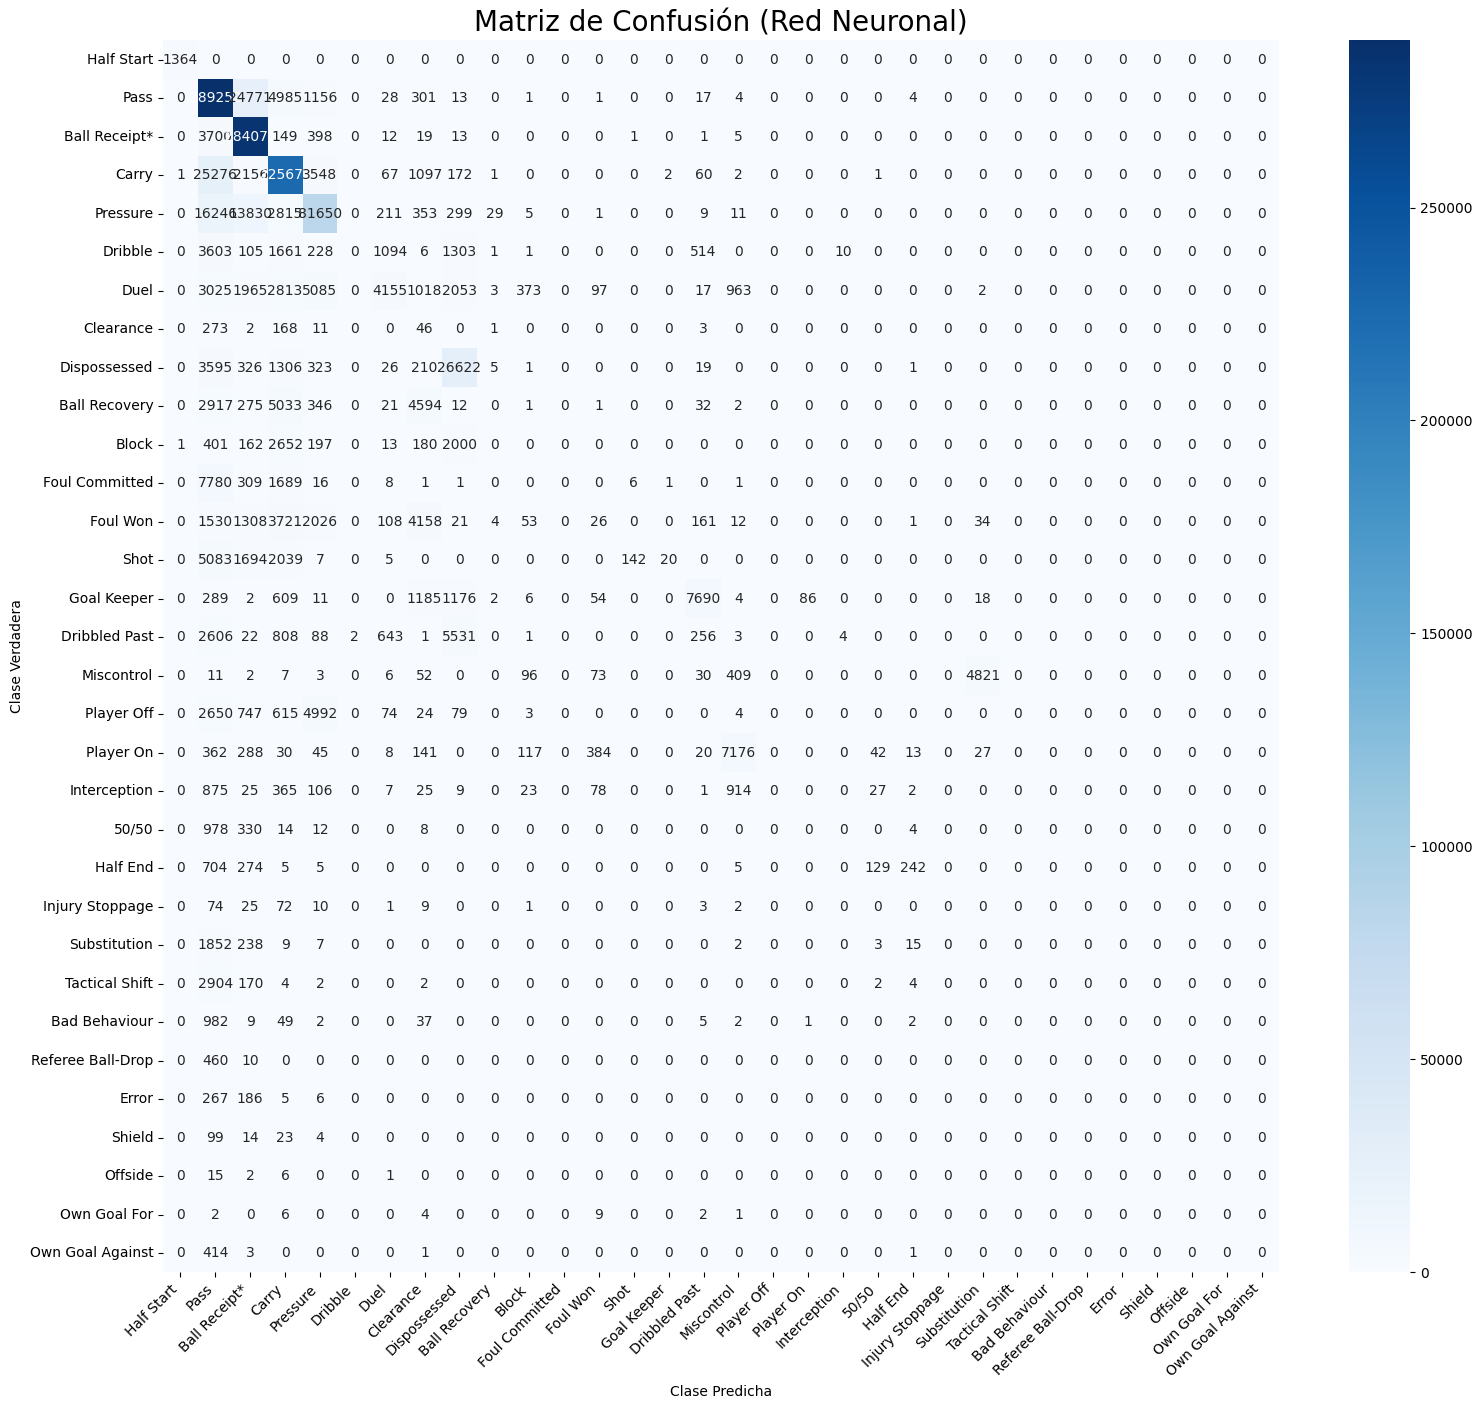

In [ ]:
target_col = 'EventTypeId'

context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

X_val_df, y_val_df = prepare_data_for_matches(df, array_season_2024_2025, 5, context_features, target_col)

event_type_names = [event_type_dict[i] for i in range(len(event_type_dict))]

evaluate_nn_performance(complex_nn_model, X_val_df, y_val_df, event_type_names)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score

# --- PASO 1: Definir la Arquitectura de la Red del Autor ---
class AuthorsNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=256):
        super(AuthorsNN, self).__init__()
        # Arquitectura: Entrada -> Capa Oculta (256 neuronas) con ReLU -> Capa de Salida
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# --- PASO 2: Función Unificada de Entrenamiento y Evaluación ---
def train_and_evaluate_authors_nn(df, train_ids, val_ids, event_type_dict, seq_len=5, epochs=5):
    """
    Prepara datos, entrena y evalúa la red neuronal replicando la del autor.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    # --- Preparación de Datos ---
    print("Preparando datos para la Red Neuronal del Autor...")
    X_train_df, y_train_df = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col)
    X_val_df, y_val_df = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col)

    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_df.values, dtype=torch.long)
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val = torch.tensor(y_val_df.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    # Usar el batch_size del autor
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

    # --- Entrenamiento ---
    input_size = X_train.shape[1]
    num_classes = len(event_type_dict)
    model = AuthorsNN(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    # Usar el learning_rate del autor
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nIniciando entrenamiento por {epochs} épocas...")
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validación al final de cada época
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f'Época [{epoch+1}/{epochs}], Precisión Validación: {val_accuracy:.2f}%')

    # --- Evaluación Final ---
    print("\n--- Evaluación Final del Modelo en Datos de Validación ---")
    model.eval()
    y_val_true = y_val.numpy()

    with torch.no_grad():
        outputs = model(X_val)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
        y_pred = torch.max(outputs, 1)[1].numpy()

    # Métricas de Evaluación
    print("\n--- Top-k Accuracy ---")
    print(f"Top-1 Accuracy: {top_k_accuracy_score(y_val_true, probabilities, k=1):.4f}")
    print(f"Top-3 Accuracy: {top_k_accuracy_score(y_val_true, probabilities, k=3):.4f}")
    print(f"Top-5 Accuracy: {top_k_accuracy_score(y_val_true, probabilities, k=5):.4f}")

    print("\n--- Reporte de Clasificación por Clase ---")
    class_names = [event_type_dict[i] for i in range(len(event_type_dict))]
    unique_labels = np.unique(y_val_true)
    filtered_class_names = [class_names[i] for i in unique_labels]
    report = classification_report(y_val_true, y_pred, labels=unique_labels, target_names=filtered_class_names, zero_division=0)
    print(report)

    return model

# --- CÓMO USARLO ---

# event_names_dict = { ... } # Tu diccionario de nombres de eventos
# (Asegúrate de tener la función 'prepare_data_for_matches')

event_names_dict = {
    0: 'Half Start', 1: 'Pass', 2: 'Ball Receipt*', 3: 'Carry', 4: 'Pressure',
    5: 'Dribble', 6: 'Duel', 7: 'Clearance', 8: 'Dispossessed', 9: 'Ball Recovery',
    10: 'Block', 11: 'Foul Committed', 12: 'Foul Won', 13: 'Shot', 14: 'Goal Keeper',
    15: 'Dribbled Past', 16: 'Miscontrol', 17: 'Player Off', 18: 'Player On',
    19: 'Interception', 20: '50/50', 21: 'Half End', 22: 'Injury Stoppage',
    23: 'Substitution', 24: 'Tactical Shift', 25: 'Bad Behaviour', 26: 'Referee Ball-Drop',
    27: 'Error', 28: 'Shield', 29: 'Offside', 30: 'Own Goal For', 31: 'Own Goal Against'
}

authors_replica_model = train_and_evaluate_authors_nn(
      df,
      array_training,
      array_season_2024_2025,
      event_names_dict,
      epochs=5
     )

Preparando datos para la Red Neuronal del Autor...

Iniciando entrenamiento por 5 épocas...
Época [1/5], Precisión Validación: 76.40%
Época [2/5], Precisión Validación: 77.30%
Época [3/5], Precisión Validación: 77.39%
Época [4/5], Precisión Validación: 77.97%
Época [5/5], Precisión Validación: 77.50%

--- Evaluación Final del Modelo en Datos de Validación ---

--- Top-k Accuracy ---
Top-1 Accuracy: 0.7750
Top-3 Accuracy: 0.8868
Top-5 Accuracy: 0.9237

--- Reporte de Clasificación por Clase ---
                   precision    recall  f1-score   support

       Half Start       1.00      1.00      1.00      1364
             Pass       0.75      0.89      0.82    320533
    Ball Receipt*       0.87      0.95      0.91    288369
            Carry       0.96      0.85      0.90    258053
         Pressure       0.82      0.60      0.69    115459
          Dribble       0.08      0.02      0.03      8526
             Duel       0.43      0.25      0.31     21569
        Clearance       0.00

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PASO 1: Preparación de Datos Modificada ---
def prepare_data_final(df, match_ids, seq_len, context_features, target_col):
    """
    Prepara los datos excluyendo los eventos de inicio y fin de tiempo.
    """
    # Filtrar eventos de inicio/fin de tiempo (IDs 0 y 21)
    df_filtered = df[~df[target_col].isin([0, 21])].copy()

    data = df_filtered[df_filtered['matchId'].isin(match_ids)].copy()

    # Crear características de contexto
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    data.fillna(-1, inplace=True)
    data.dropna(inplace=True)

    y = data[target_col]
    features_to_drop = [target_col, 'eventSec', 'matchId']
    X = data.drop(columns=[col for col in features_to_drop if col in data.columns])

    return X, y

# --- PASO 2: Definir la Arquitectura de la Red del Autor ---
class AuthorsModelTypeNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=256):
        super(AuthorsModelTypeNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.network(x)

# --- PASO 3: Función de Entrenamiento ---
def train_final_model_type(df, train_ids, val_ids, epochs=5):
    """
    Prepara datos y entrena la réplica del 'Model Type' del autor.
    """
    target_col = 'EventTypeId'
    context_features = ['EventTypeId', 'X', 'Y', 'IsHomeTeam', 'IsAccurate', 'IsGoal', 'TimeDelta']

    print("Preparando datos (excluyendo Half Start/End)...")
    X_train_df, y_train_df = prepare_data_final(df, train_ids, 5, context_features, target_col)
    X_val_df, y_val_df = prepare_data_final(df, val_ids, 5, context_features, target_col)

    # Re-mapear las etiquetas para que sean contiguas (ej. 0, 1, 2,...)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_df)
    y_val_encoded = le.transform(y_val_df)

    X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
    y_train = torch.tensor(y_train_encoded, dtype=torch.long)
    X_val = torch.tensor(X_val_df.values, dtype=torch.float32)
    y_val = torch.tensor(y_val_encoded, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

    input_size = X_train.shape[1]
    num_classes = len(le.classes_)
    model = AuthorsModelTypeNN(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"\nIniciando entrenamiento por {epochs} épocas...")
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f'Época [{epoch+1}/{epochs}], Precisión de Validación: {val_accuracy:.2f}%')

    print("\nEntrenamiento completado.")
    # Devolvemos el modelo, el encoder y los datos de validación para la evaluación
    return model, le, X_val_df, y_val_df

# --- CÓMO USARLO ---

final_model_type, label_encoder, X_val_final, y_val_final = train_final_model_type(
     df,
     array_training,
     array_season_2024_2025,
     epochs=5
     )

Preparando datos (excluyendo Half Start/End)...

Iniciando entrenamiento por 5 épocas...
Época [1/5], Precisión de Validación: 80.55%
Época [2/5], Precisión de Validación: 81.16%
Época [3/5], Precisión de Validación: 80.19%
Época [4/5], Precisión de Validación: 80.83%
Época [5/5], Precisión de Validación: 80.29%

Entrenamiento completado.
